# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import functions as cf
%matplotlib inline

# General information:

The midbootcamp project: Can we predict cancer using gene expression profile?

# To approach this objective:

1. select gene expression datasets for different types of cancers
2. Data checking, cleaning, transform if needed
3. Identify genes that are differentially expressed (called DEGs) in cancer samples vs normal samples. Using two samples t-test at p_sig = 0.05
4. Check and excluding genes that are highly correlated among the identified DEGs subset with a threshold for exluding at 0.95
5. Split and train model on working datasets:
    * sing transformed data (using quantile transformation) vs non-transformed data
6. Validation:
    * on the whole (train + test) dataset
    * using a new dataset of the same cancer type
    * calculation all validation metrics: precision, accuracy, recel, F1, cohen_kappa_score

# From the GEO database, we selected 3 expression profiling datasets for 3 types of cancers: prostate, breats, leukemia

1. link for download gene expression dataset: https://sbcb.inf.ufrgs.br/cumida
2. every dataset has it unique identifier as accession number GSE
3. For breast cancer dataset, accession number is GSE22820
   * Description: it is expression profiling by array, generated from 176 primary breast cancer patients and 10 normal breast samples.
   * NOTE: however, when loading this dataset, there are only 129 primary breast cancer patients and 10 normal breast samples. This should not affect the analysis.
4. since these datasets are repositories from different research groups to NCBI database (GEO), the format and setup is already standardized. Therefore, most likely, it will not require a lot of cleaning.

# Load Dataset from CSV with Pandas

In [2]:
# load the gene expression datasets GSE...
DataSet1 = '../Raw_Data/Breast_GSE22820.csv'
DataSet2 = '../Raw_Data/Breast_GSE38959.csv'

df = pd.read_csv(DataSet1)
df.head()

# change type values to 1 = 'primary_breast_cancer', and 0 = 'normal'
df.replace(to_replace = 'primary_breast_cancer', value = '1', inplace = True)
df.replace(to_replace = 'normal', value = '0', inplace = True)
df.head()

,samples,type,NM_004900,AA085955,NM_014616,AK092846,NM_001539,THC2450799,NM_006709,NM_000978,...,AF117899,A_24_P287526,THC2349421,THC2272949,NM_138411,THC2350949,CR600872,NM_016058,AF520801,NM_203414
0,GSM563920_1,1,7.642101,4.803022,7.939666,5.790127,12.162603,5.378933,9.117912,13.907735,...,5.420074,5.535341,7.087367,5.940366,9.781396,4.740855,6.037292,8.960350,4.578823,8.486862
1,GSM563922_3,1,4.758954,5.150573,6.568998,5.352497,12.067264,4.606413,7.502331,14.625330,...,5.303676,5.303676,6.215967,4.731728,9.725169,5.381360,6.315188,9.064591,4.453024,9.982885
2,GSM563923_4,1,6.423254,4.408955,8.668739,4.979653,11.704731,6.466557,7.671957,13.580480,...,6.002756,6.023807,5.409657,5.036619,8.164628,5.230133,5.604062,10.090701,4.354638,8.361384
3,GSM563924_5,1,8.385947,4.454648,8.721586,5.121018,11.228727,5.390309,7.610587,13.933777,...,5.162009,5.176968,6.425804,4.810718,8.025828,4.511641,5.826439,9.580325,4.352350,7.998807
4,GSM563925_6,1,7.630389,4.598275,8.387313,5.221780,11.863483,4.501516,7.184051,14.535956,...,5.398244,5.345064,6.235113,4.618548,9.012896,6.544705,5.465001,10.584008,4.356300,7.862625


# Perform a Quantile Transformation

Quantile transformation is applied to gene expression data to normalize its distribution, addressing issues of skewness and outliers. By reshaping the data to adhere to a standard normal distribution, quantile transformation ensures statistical consistency, mitigates the impact of outliers, and improves the performance of certain analyses and machine learning models that assume normally distributed input. This preprocessing step enhances interpretability and facilitates valid comparisons across different datasets.

# Explore the data

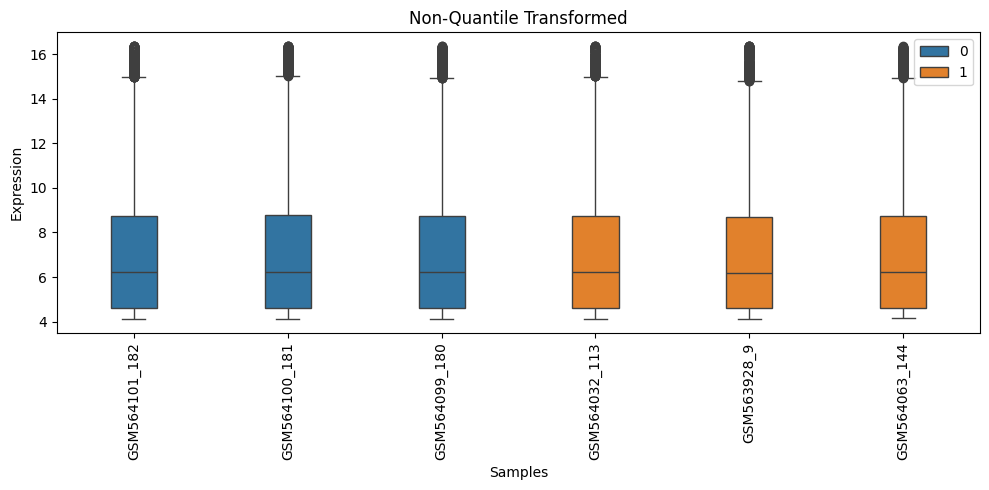

In [11]:
# Create two melted dataframes to explore within graphs
melted_df = df.melt(id_vars=['samples', 'type'], var_name='gene', value_name='expression').sort_values('type')
#melted_df_transformed = df_transformed.melt(id_vars=['samples', 'type'], var_name='gene', value_name='expression').sort_values('type')

# get samples from  Melts for plotting
import random
random_cancer_list = random.sample(df[df['type'] =='1']['samples'].tolist(),3)
random_normal_list = random.sample(df[df['type'] == '0']['samples'].tolist(),3)

#qt_set = melted_df_transformed.copy()
#qt_set = qt_set[qt_set['samples'].isin(random_cancer_list + random_normal_list)]

df_set = melted_df.copy()
df_set = df_set[df_set['samples'].isin(random_cancer_list + random_normal_list)]


# plot log transformed data on boxplot
f, ax = plt.subplots(1,1,figsize=(10, 5), sharey=True, sharex=True)
#sns.boxplot(x='samples', y='expression', hue = 'type',  data=qt_set, width = 0.3, ax=ax[1])
sns.boxplot(x='samples', y='expression', hue = 'type',  data=df_set, width = 0.3, ax=ax)
plt.xticks(rotation = 90)

# Rotate x-tick labels for both subplots
#for axis in ax:
#    axis.tick_params(axis='x', rotation=90)
    
# Set titles, Labels and legendas
#ax[1].legend([])
ax.legend(loc='upper right')

#ax[1].set_title('Quantile Transformed')
ax.set_title('Non-Quantile Transformed')

ax.set_xlabel('Samples')
#ax[1].set_xlabel('Samples')
ax.set_ylabel('Expression')

# Show the plot
plt.tight_layout()
plt.show()


# Perform a two sample T Test

A two-sample t-test is employed to assess whether there is a significant difference in the mean expression levels between tumoral and normal genes. This statistical test is applied to identify genes that exhibit a statistically significant impact on the tumoral set compared to the normal set. By isolating genes with significant differences, researchers can focus on those likely to play a role in tumorigenesis, aiding in the identification of potential biomarkers or therapeutic targets.

In [12]:
# identify differential expressed genes

differential_expressed_genes = cf.getListDifferentialGenes(df, tumor_value = '1', tumor_column = 'type')
print(len(differential_expressed_genes))

19490


In [13]:
# create new set to only include the differential expressed genes 
df_DEG = df.copy()
df_DEG = df_DEG[['samples', 'type'] + differential_expressed_genes]

In [14]:
# check the new set
df_DEG

,samples,type,NM_004900,NM_014616,AK092846,NM_001539,THC2450799,NM_000978,T12590,NM_001017,...,NM_024887,NM_021168,NM_005086,AK096148,BX414807,AL832183,AF117899,THC2349421,THC2272949,NM_203414
0,GSM563920_1,1,7.642101,7.939666,5.790127,12.162603,5.378933,13.907735,4.918658,13.533483,...,6.740345,9.571465,8.155324,6.037292,6.186230,11.113530,5.420074,7.087367,5.940366,8.486862
1,GSM563922_3,1,4.758954,6.568998,5.352497,12.067264,4.606413,14.625330,4.883529,14.487884,...,6.102728,9.242387,8.232784,6.107088,4.795892,11.119205,5.303676,6.215967,4.731728,9.982885
2,GSM563923_4,1,6.423254,8.668739,4.979653,11.704731,6.466557,13.580480,4.551058,14.220230,...,6.786114,8.892251,10.527390,5.308463,5.896109,11.935986,6.002756,5.409657,5.036619,8.361384
3,GSM563924_5,1,8.385947,8.721586,5.121018,11.228727,5.390309,13.933777,4.744501,13.557500,...,6.671023,7.619908,9.685097,5.841109,4.999826,12.159585,5.162009,6.425804,4.810718,7.998807
4,GSM563925_6,1,7.630389,8.387313,5.221780,11.863483,4.501516,14.535956,5.137961,14.154754,...,6.154131,7.763267,9.647408,5.701639,5.788941,11.530416,5.398244,6.235113,4.618548,7.862625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,GSM564101_182,0,7.389932,8.486529,5.032610,11.364942,5.981754,14.159944,4.621662,14.072302,...,6.896548,7.968914,10.259590,5.531316,4.936424,12.053818,5.602249,5.079415,4.970296,9.385845
135,GSM564102_183,0,6.396778,9.453966,5.234155,11.380491,7.349289,14.958784,4.663486,14.368535,...,6.640277,7.756662,11.401666,6.076080,5.022355,13.644152,5.724029,5.910954,5.183218,9.461447
136,GSM564103_184,0,6.465171,9.053491,4.761524,11.441499,7.498902,14.058164,4.616924,13.954264,...,7.551332,8.055169,10.624326,5.401489,5.735350,12.886619,6.335111,5.301914,5.177253,8.371678
137,GSM564104_185,0,5.728902,9.008859,4.827861,11.527671,6.404394,14.198314,4.608138,13.964812,...,7.160949,7.864288,10.907326,5.034105,5.199878,11.960737,6.067234,5.639116,4.931638,9.250493


# Model training without excluding genes that are highly correlated

/Users/minhnguyen/IronHack2023-2024/Bootcamp/Labs/5_Mid_bootcamp_project_venv/notebooks/functions.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df2[ColumnToPredict].value_counts()[0] != df2[ColumnToPredict].value_counts()[1]:
/Users/minhnguyen/IronHack2023-2024/Bootcamp/Labs/5_Mid_bootcamp_project_venv/notebooks/functions.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df2[ColumnToPredict].value_counts()[0] != df2[ColumnToPredict].value_counts()[1]:


The scores of the model are:
accuracy : 0.98 
precision : 1.0 
recall : 0.98 
f1 : 0.99 
kappa : 0.9 


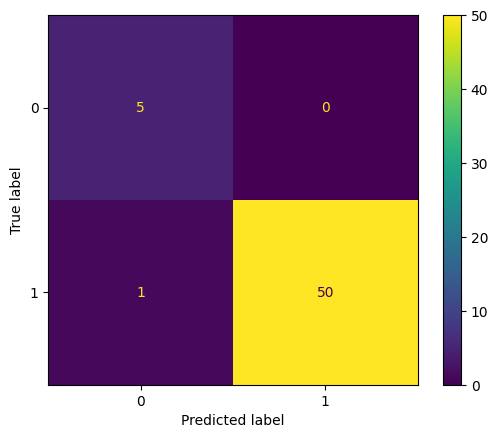

In [15]:
# model training and evaluation (on the test set) without get rid of correlated variables using cf.trainLogisticModel
model, cm, scores = cf.trainLogisticModel(df_DEG, ColumnToPredict='type', tumor_value = '1')

print('The scores of the model are:')
for key in scores.keys():
    print(f"{key} : {round(scores[key],2)} ")

# Validation of model using the whole current set, and a new dataset with the same cancer type

In [16]:
# on the whole current set GSE22820
y_pred = model.predict(X = df_DEG.drop(columns = ['samples', 'type']))
y_test = df_DEG['type']

(LogisticRegression(random_state=0),
 array([[ 10,   0],
        [  2, 127]]),
 {'accuracy': 0.9856115107913669,
  'precision': 1.0,
  'recall': 0.9844961240310077,
  'f1': 0.9921875,
  'kappa': 0.9013484740951029})

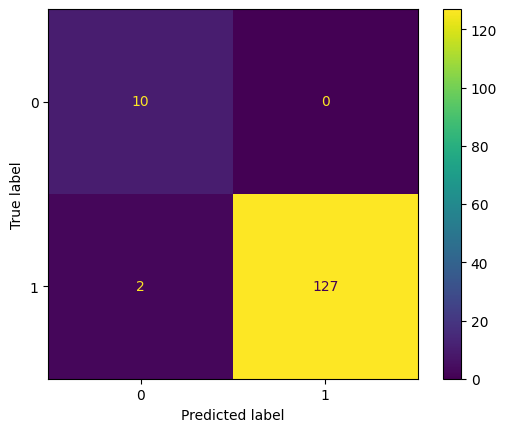

In [17]:
# test on the whole set GSE22820
cf.LogisticModelView(model, y_pred, y_test, pos_label = '1')

# Load Different dataset and compare

The trained models, including the quantile-transformed data, two-sample t-test filtering, and correlation-filtered gene set, are deployed to predict normal or tumoral labels for a different dataset from the same cancer type. This external dataset serves as a valuable test set, assessing the generalization performance of the models. The ability of the models to accurately classify samples in this new data provides insights into their robustness and potential applicability to diverse datasets within the same cancer type.

In [18]:
# load dataset 2 GSE38959.csv
main2 = pd.read_csv(DataSet2)
main2.head()

# change 'type' values to 1 = 'triple_negative_breast_cancer', and 0 = 'normal'
main2.replace(to_replace = 'triple_negative_breast_cancer', value = '1', inplace = True)
main2.replace(to_replace = 'normal', value = '0', inplace = True)
main2.head()

,samples,type,NM_004900,AA085955,NM_014616,AK092846,NM_001539,THC2450799,NM_006709,NM_000978,...,AF117899,A_24_P287526,THC2349421,THC2272949,NM_138411,THC2350949,CR600872,NM_016058,AF520801,NM_203414
0,GSM952871_US45103014_251485050411_S01_GE1-v5_9...,1,5.397972,4.878910,6.328569,4.562055,10.183883,4.377609,4.852302,12.097979,...,7.357777,5.213975,4.454014,5.983366,4.632281,4.747501,4.507341,7.737400,4.499438,4.878910
1,GSM952872_US45103014_251485050411_S01_GE1-v5_9...,1,5.679156,7.108852,4.706115,6.219244,11.020998,4.627557,5.112524,13.290506,...,7.352243,5.032044,4.683446,4.673856,4.490288,4.356829,6.351861,6.440282,4.362710,4.976353
2,GSM952873_US45103014_251485050411_S01_GE1-v5_9...,1,4.935842,7.060972,6.999370,4.579123,11.142480,4.514081,4.796740,13.039557,...,7.336034,5.115805,4.567063,4.514081,4.438267,4.446520,6.302137,6.816790,4.421894,5.248685
3,GSM952874_US45103014_251485050412_S01_GE1-v5_9...,1,5.216894,6.815301,5.657906,4.438267,9.673847,4.511823,5.072225,13.277404,...,7.206526,5.440784,4.583486,4.556824,4.681703,4.466248,6.630745,7.044292,4.358895,6.321352
4,GSM952875_US45103014_251485050412_S01_GE1-v5_9...,1,4.706115,4.465668,5.229207,6.245122,9.832268,4.422589,5.471139,13.268857,...,7.626914,4.852302,4.837053,4.566795,4.920688,4.410083,5.453399,6.944313,4.496288,6.779711


In [ ]:
# Perform transformation based on previously created qt model
#df_transformed2, qt = cf.quantileTransformer(main2, qt=qt)

In [19]:
# Create final set based on final_set list
final_set2 = main2[['samples', 'type'] + differential_expressed_genes]
final_set2.head()

,samples,type,NM_004900,NM_014616,AK092846,NM_001539,THC2450799,NM_000978,T12590,NM_001017,...,NM_024887,NM_021168,NM_005086,AK096148,BX414807,AL832183,AF117899,THC2349421,THC2272949,NM_203414
0,GSM952871_US45103014_251485050411_S01_GE1-v5_9...,1,5.397972,6.328569,4.562055,10.183883,4.377609,12.097979,5.526607,11.392016,...,9.169144,5.199356,6.893717,7.849947,6.566178,10.293521,7.357777,4.454014,5.983366,4.878910
1,GSM952872_US45103014_251485050411_S01_GE1-v5_9...,1,5.679156,4.706115,6.219244,11.020998,4.627557,13.290506,8.766883,10.758119,...,8.601909,7.085265,10.041702,6.728584,6.428450,8.131271,7.352243,4.683446,4.673856,4.976353
2,GSM952873_US45103014_251485050411_S01_GE1-v5_9...,1,4.935842,6.999370,4.579123,11.142480,4.514081,13.039557,8.244181,10.863387,...,8.594854,6.060474,7.582531,6.889479,6.517844,8.886111,7.336034,4.567063,4.514081,5.248685
3,GSM952874_US45103014_251485050412_S01_GE1-v5_9...,1,5.216894,5.657906,4.438267,9.673847,4.511823,13.277404,6.354835,11.581607,...,8.311310,4.885385,6.876973,6.820802,6.372253,9.836531,7.206526,4.583486,4.556824,6.321352
4,GSM952875_US45103014_251485050412_S01_GE1-v5_9...,1,4.706115,5.229207,6.245122,9.832268,4.422589,13.268857,8.482841,10.600034,...,7.575073,7.100870,5.453399,7.539718,5.694147,10.546773,7.626914,4.837053,4.566795,6.779711


**Use existing Model to calculate y_pred and confusing Matrix**

The scores of the model are:
accuracy : 0.93 
precision : 0.91 
recall : 1.0 
f1 : 0.95 
kappa : 0.82 


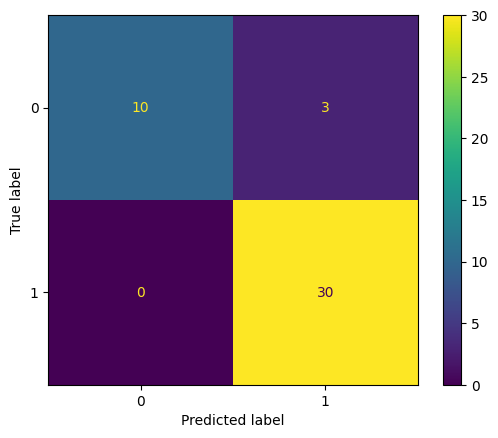

In [20]:
# Create X, y sets
y = final_set2['type']
X = final_set2.drop(['samples', 'type'], axis=1)

y_pred3 = model.predict(X=X)

model, cm, scores = cf.LogisticModelView(model, y_pred3, y_test=y, pos_label='1')

print('The scores of the model are:')
for key in scores.keys():
    print(f"{key} : {round(scores[key],2)} ")

# Save Models

In [21]:
import os
import pickle

def savemodel(model, path, filename):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
        print("The new directory is created!")

    with open(path+filename, "wb") as file:
        pickle.dump(model, file)


#savemodel(qt, './Transformer/', 'minh_Breast_GSE22820_qt.pkl')
savemodel(model, './Models/', 'minh_Breast_GSE22820.pkl')

# Model training with excluding genes that are highly correlated

In [23]:
# calculate correlation matrix among differential expressed genes, on GSE22820 dataset1
corr_matrix = df[differential_expressed_genes].corr()
corr_matrix

,NM_004900,NM_014616,AK092846,NM_001539,THC2450799,NM_000978,T12590,NM_001017,NM_000311,AK091028,...,NM_024887,NM_021168,NM_005086,AK096148,BX414807,AL832183,AF117899,THC2349421,THC2272949,NM_203414
NM_004900,1.000000,0.093490,0.079161,0.320529,-0.226062,-0.278840,-0.006746,-0.157603,0.168783,-0.350136,...,-0.090765,-0.227356,-0.097135,0.330230,0.066793,-0.028143,0.072722,-0.142180,0.303745,-0.063048
NM_014616,0.093490,1.000000,-0.176092,0.116271,-0.161422,-0.141226,-0.234667,-0.027101,0.315804,-0.073984,...,0.189011,-0.193066,0.321814,0.171925,-0.084393,0.179174,0.061815,-0.096108,0.226750,0.016664
AK092846,0.079161,-0.176092,1.000000,0.117795,0.081581,0.108563,0.091432,-0.069342,-0.073314,-0.094043,...,-0.256239,0.117177,-0.215860,0.118203,0.107614,-0.099789,-0.153021,0.061695,0.014345,0.117928
NM_001539,0.320529,0.116271,0.117795,1.000000,-0.286041,-0.121506,-0.137278,-0.069397,0.276132,-0.279253,...,-0.004737,-0.142349,-0.125134,0.391127,0.023855,-0.207753,-0.263083,0.046106,0.061100,-0.089938
THC2450799,-0.226062,-0.161422,0.081581,-0.286041,1.000000,0.182242,0.028506,0.074482,-0.063072,0.240480,...,-0.054184,0.097587,0.203347,-0.229731,-0.002640,0.025579,0.258495,0.005723,-0.173204,0.022740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL832183,-0.028143,0.179174,-0.099789,-0.207753,0.025579,0.013993,-0.209962,0.151770,0.209756,0.123357,...,0.172998,-0.072589,0.327738,0.006327,-0.107510,1.000000,0.145286,-0.086830,0.152936,0.090072
AF117899,0.072722,0.061815,-0.153021,-0.263083,0.258495,-0.267938,0.047514,-0.211483,-0.189461,0.114145,...,0.380523,0.204251,0.014489,-0.170457,0.009570,0.145286,1.000000,-0.018607,0.099431,-0.055570
THC2349421,-0.142180,-0.096108,0.061695,0.046106,0.005723,-0.120981,-0.284038,-0.225992,-0.284762,-0.205667,...,0.214144,0.353969,-0.379031,0.196262,-0.040925,-0.086830,-0.018607,1.000000,0.025054,-0.035784
THC2272949,0.303745,0.226750,0.014345,0.061100,-0.173204,-0.069557,-0.218305,0.025837,0.224899,-0.435833,...,-0.016746,-0.279620,-0.090060,0.202647,0.324845,0.152936,0.099431,0.025054,1.000000,0.090015


In [ ]:
type(corr_matrix)

In [24]:
def find_correlated_genes_optimized(corr: pd.DataFrame, threshold=0.95):
    """
    Identify and analyze genes with high correlation coefficients in a gene expression DataFrame.
    Experimental function, "optimized" from the previous. This function loops over till no mutlicollinearity is found, but will take slightly longer.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing gene expression data.
    - threshold (float, optional): The correlation coefficient threshold for identifying highly correlated genes. Default is 0.95.

    Returns:
    - List: Names of genes to be excluded to avoid redundancy.
    """
    exclude_list = []
    corr2 = corr.copy()

    # Create mask over all columns
    while True:
        mask = (corr2.to_numpy() > threshold) & (corr2.index.to_numpy() != corr2.columns.to_numpy()[:, None])
        correlated_columns, correlated_rows = np.where(mask)
    
        correlated_genes_list = {}
        for col, index in zip(corr2.columns[correlated_columns], corr2.index[correlated_rows]):
            count = correlated_genes_list.get(col, 0)
            count += 1
            correlated_genes_list[col] = count

        count_df = pd.DataFrame(correlated_genes_list, index=[0]).melt().sort_values('value', ascending=False)
        highest_col_value = count_df['value'].iloc[0]

        if highest_col_value <= 1:
            break

        highest_count_genes = count_df[count_df['value'] == highest_col_value]['variable'].tolist()

        exclude_list.extend(highest_count_genes)
        corr2 = corr2.drop(highest_count_genes, axis=1)
        corr2 = corr2.drop(highest_count_genes)

        print(f"Loop completed, highest value was {highest_col_value} from genes {highest_count_genes}")

    return exclude_list


In [25]:
# filtered for the list of highly correlated genes
exclude_list = find_correlated_genes_optimized(corr_matrix, threshold=0.95)

Loop completed, highest value was 22 from genes ['A_24_P186746']
Loop completed, highest value was 13 from genes ['ENST00000331696']
Loop completed, highest value was 12 from genes ['A_24_P306704', 'A_24_P6850']
Loop completed, highest value was 11 from genes ['ENST00000310579', 'NM_003520']
Loop completed, highest value was 10 from genes ['A_24_P247454']
Loop completed, highest value was 9 from genes ['A_24_P584463', 'AI878825', 'A_24_P358606', 'A_32_P140312', 'A_24_P350060', 'BC067092']
Loop completed, highest value was 8 from genes ['NM_003528', 'NM_017445', 'NM_175055']
Loop completed, highest value was 7 from genes ['S73202', 'A_24_P230466', 'ENST00000295339', 'A_24_P101742', 'A_24_P490109', 'BC030813', 'A_24_P178444', 'A_23_P44053', 'A_24_P792988', 'ENST00000259219', 'A_24_P358131', 'A_24_P109661', 'BC095489', 'ENST00000359488', 'ENST00000295410', 'A_24_P306814']
Loop completed, highest value was 6 from genes ['NM_033178', 'NM_005477', 'A_32_P112100', 'ENST00000379440']
Loop comp

In [26]:
# check the list of highly correlated genes
display(len(exclude_list))
exclude_list

112

['A_24_P186746',
 'ENST00000331696',
 'A_24_P306704',
 'A_24_P6850',
 'ENST00000310579',
 'NM_003520',
 'A_24_P247454',
 'A_24_P584463',
 'AI878825',
 'A_24_P358606',
 'A_32_P140312',
 'A_24_P350060',
 'BC067092',
 'NM_003528',
 'NM_017445',
 'NM_175055',
 'S73202',
 'A_24_P230466',
 'ENST00000295339',
 'A_24_P101742',
 'A_24_P490109',
 'BC030813',
 'A_24_P178444',
 'A_23_P44053',
 'A_24_P792988',
 'ENST00000259219',
 'A_24_P358131',
 'A_24_P109661',
 'BC095489',
 'ENST00000359488',
 'ENST00000295410',
 'A_24_P306814',
 'NM_033178',
 'NM_005477',
 'A_32_P112100',
 'ENST00000379440',
 'A_24_P264644',
 'NM_000224',
 'ENST00000361266',
 'BC028083',
 'NM_020070',
 'A_23_P113056',
 'NM_001504',
 'NM_003523',
 'BC070333',
 'A_24_P533990',
 'BC012876',
 'A_23_P435390',
 'NM_003519',
 'A_24_P384369',
 'NM_001767',
 'NM_001013618',
 'A_24_P152345',
 'ENST00000303934',
 'XM_928128',
 'AF119895',
 'NM_003521',
 'NM_000526',
 'NM_014417',
 'ENST00000270031',
 'A_24_P499481',
 'A_24_P745352',
 'NM_

In [27]:
# create a dataframe with differential expressed genes (excluding the highly correlated genes)
df_DEG_no_corr = df_DEG.drop(exclude_list, axis = 1)
df_DEG_no_corr

,samples,type,NM_004900,NM_014616,AK092846,NM_001539,THC2450799,NM_000978,T12590,NM_001017,...,NM_024887,NM_021168,NM_005086,AK096148,BX414807,AL832183,AF117899,THC2349421,THC2272949,NM_203414
0,GSM563920_1,1,7.642101,7.939666,5.790127,12.162603,5.378933,13.907735,4.918658,13.533483,...,6.740345,9.571465,8.155324,6.037292,6.186230,11.113530,5.420074,7.087367,5.940366,8.486862
1,GSM563922_3,1,4.758954,6.568998,5.352497,12.067264,4.606413,14.625330,4.883529,14.487884,...,6.102728,9.242387,8.232784,6.107088,4.795892,11.119205,5.303676,6.215967,4.731728,9.982885
2,GSM563923_4,1,6.423254,8.668739,4.979653,11.704731,6.466557,13.580480,4.551058,14.220230,...,6.786114,8.892251,10.527390,5.308463,5.896109,11.935986,6.002756,5.409657,5.036619,8.361384
3,GSM563924_5,1,8.385947,8.721586,5.121018,11.228727,5.390309,13.933777,4.744501,13.557500,...,6.671023,7.619908,9.685097,5.841109,4.999826,12.159585,5.162009,6.425804,4.810718,7.998807
4,GSM563925_6,1,7.630389,8.387313,5.221780,11.863483,4.501516,14.535956,5.137961,14.154754,...,6.154131,7.763267,9.647408,5.701639,5.788941,11.530416,5.398244,6.235113,4.618548,7.862625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,GSM564101_182,0,7.389932,8.486529,5.032610,11.364942,5.981754,14.159944,4.621662,14.072302,...,6.896548,7.968914,10.259590,5.531316,4.936424,12.053818,5.602249,5.079415,4.970296,9.385845
135,GSM564102_183,0,6.396778,9.453966,5.234155,11.380491,7.349289,14.958784,4.663486,14.368535,...,6.640277,7.756662,11.401666,6.076080,5.022355,13.644152,5.724029,5.910954,5.183218,9.461447
136,GSM564103_184,0,6.465171,9.053491,4.761524,11.441499,7.498902,14.058164,4.616924,13.954264,...,7.551332,8.055169,10.624326,5.401489,5.735350,12.886619,6.335111,5.301914,5.177253,8.371678
137,GSM564104_185,0,5.728902,9.008859,4.827861,11.527671,6.404394,14.198314,4.608138,13.964812,...,7.160949,7.864288,10.907326,5.034105,5.199878,11.960737,6.067234,5.639116,4.931638,9.250493


/Users/minhnguyen/IronHack2023-2024/Bootcamp/Labs/5_Mid_bootcamp_project_venv/notebooks/functions.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df2[ColumnToPredict].value_counts()[0] != df2[ColumnToPredict].value_counts()[1]:
/Users/minhnguyen/IronHack2023-2024/Bootcamp/Labs/5_Mid_bootcamp_project_venv/notebooks/functions.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df2[ColumnToPredict].value_counts()[0] != df2[ColumnToPredict].value_counts()[1]:


The scores of the model are:
accuracy : 0.98 
precision : 1.0 
recall : 0.98 
f1 : 0.99 
kappa : 0.9 


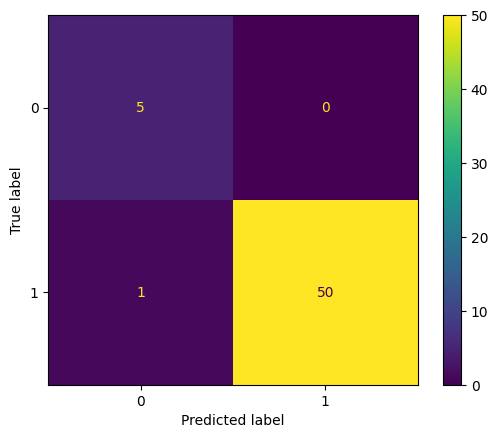

In [28]:
# model training and evaluation (on the test set) (no highly correlated genes) using cf.trainLogisticModel
model_no_corr, cm, scores = cf.trainLogisticModel(df_DEG_no_corr, ColumnToPredict='type', tumor_value = '1')

print('The scores of the model are:')
for key in scores.keys():
    print(f"{key} : {round(scores[key],2)} ")

In [29]:
# validation on the whole current set GSE22820
# 1. prepare y_pred, y_test
y_pred_1 = model_no_corr.predict(X = df_DEG_no_corr.drop(columns = ['samples', 'type']))
y_test_1 = df_DEG_no_corr['type']

(LogisticRegression(random_state=0),
 array([[ 10,   0],
        [  2, 127]]),
 {'accuracy': 0.9856115107913669,
  'precision': 1.0,
  'recall': 0.9844961240310077,
  'f1': 0.9921875,
  'kappa': 0.9013484740951029})

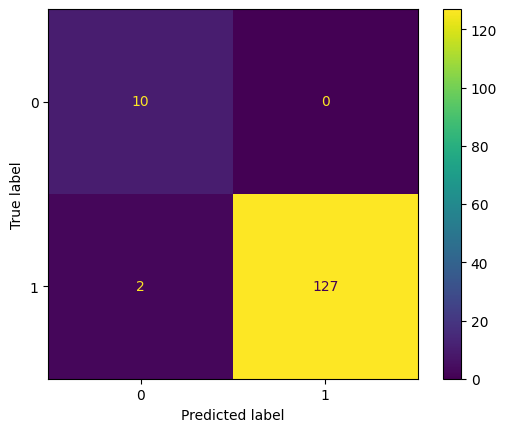

In [30]:
# validation on the whole set GSE22820
# 2. run model prediction, and get evalutation metrics
cf.LogisticModelView(model_no_corr, y_pred_1, y_test_1, pos_label = '1')

In [31]:
# test on dataset 2 GSE38959

# Create final set with differential expressed genes (excluding highly correlated genes):
final_set2_no_corr = final_set2.drop(exclude_list, axis = 1)
final_set2_no_corr.head()

,samples,type,NM_004900,NM_014616,AK092846,NM_001539,THC2450799,NM_000978,T12590,NM_001017,...,NM_024887,NM_021168,NM_005086,AK096148,BX414807,AL832183,AF117899,THC2349421,THC2272949,NM_203414
0,GSM952871_US45103014_251485050411_S01_GE1-v5_9...,1,5.397972,6.328569,4.562055,10.183883,4.377609,12.097979,5.526607,11.392016,...,9.169144,5.199356,6.893717,7.849947,6.566178,10.293521,7.357777,4.454014,5.983366,4.878910
1,GSM952872_US45103014_251485050411_S01_GE1-v5_9...,1,5.679156,4.706115,6.219244,11.020998,4.627557,13.290506,8.766883,10.758119,...,8.601909,7.085265,10.041702,6.728584,6.428450,8.131271,7.352243,4.683446,4.673856,4.976353
2,GSM952873_US45103014_251485050411_S01_GE1-v5_9...,1,4.935842,6.999370,4.579123,11.142480,4.514081,13.039557,8.244181,10.863387,...,8.594854,6.060474,7.582531,6.889479,6.517844,8.886111,7.336034,4.567063,4.514081,5.248685
3,GSM952874_US45103014_251485050412_S01_GE1-v5_9...,1,5.216894,5.657906,4.438267,9.673847,4.511823,13.277404,6.354835,11.581607,...,8.311310,4.885385,6.876973,6.820802,6.372253,9.836531,7.206526,4.583486,4.556824,6.321352
4,GSM952875_US45103014_251485050412_S01_GE1-v5_9...,1,4.706115,5.229207,6.245122,9.832268,4.422589,13.268857,8.482841,10.600034,...,7.575073,7.100870,5.453399,7.539718,5.694147,10.546773,7.626914,4.837053,4.566795,6.779711


The scores of the model are:
accuracy : 0.93 
precision : 0.91 
recall : 1.0 
f1 : 0.95 
kappa : 0.82 


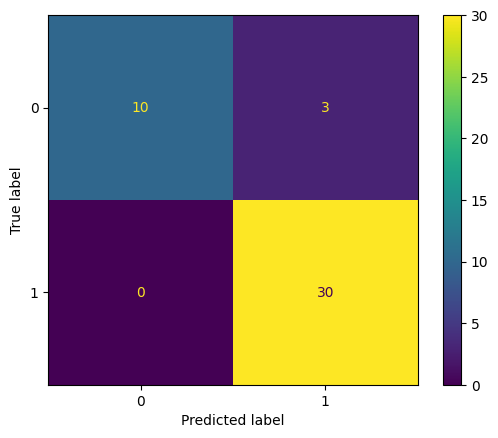

In [32]:
# Create X, y sets, and predict
y = final_set2_no_corr['type']
X = final_set2_no_corr.drop(['samples', 'type'], axis=1)

y_pred4 = model_no_corr.predict(X=X)

model, cm, scores = cf.LogisticModelView(model_no_corr, y_pred4, y_test=y, pos_label='1')

print('The scores of the model are:')
for key in scores.keys():
    print(f"{key} : {round(scores[key],2)} ")

In [ ]:
correlated_genes_list[0]